# Classical Molecular Dynamics

Classical molecular dynamics with Crystal classes.

In [1]:
import sys
sys.path.append('../') 

---

## Initialize a CrystalStructure object

### Build the object

A crystal is built from a file containing atoms' coordinates. It must have 3 coordinates (x y z) for each row.

In [2]:
from libraries.CrystalStructure import CrystalStructure as Crystal
# Insert a valid file name here
filename = '../../data/fcc100a256.txt'
# Initialize a Crystal object using the from_file method (constructor)
cristallo = Crystal.from_file(filename)

### Find and store distances

With the `find_neighbours()` method it is possible to find all neighbours for each atom and their respective distances. In respect to an atom, another atom of the crystal is considered as neighbour if its distance is less than a *cutoff radious* $R_C$.

In [3]:
# First set a cutoff radious = 4.5 Angstrom
cristallo.set_R_C(4.5)
# Then find neighbours
cristallo.find_neighbours() 

This line of code triggers the creation of three members in the object `cristallo`:
- `cristallo.N_neighbours` 
    - list of scalars 
    - $i$-th entry is the number of neighbours of $i$-th atom
- `cristallo.which_neighbour`
    - list of lists 
    - $i$-th entry is the indexes' list of the neighbours of $i$-th atom
- `cristallo.how_distant`
    - list of lists 
    - $i$-th entry is the distances' list of $i$-th atom from his neighbours
    - the order of appearance of the distances matches the order in `.which_neighbour`; this means that its first entry .how_distant[i][0] is the distance between atom `i` and atom `.which_neighbour[i][0]`

---

## Calculate potential energy leveraging CrystalPotential

### Theoretical background

After `find_neighbours()` execution, the neighbours and distances attributes of each atom in the crystal are populated. Having these informations, the potential energy of the system can be calculated as the sum of each couples' Lennard-Jones' potentials.
In math:
$$
V = \frac12 \sum_{i\neq j \atop i,j=1}^{N} \phi(r_{ij})
$$
where $\phi$ is Lennard-Jones' potential:
$$
\phi(r_{ij}) = 4\varepsilon\left[
    \left( \frac{\sigma}{r_{ij}} \right)^{12} -
    \left( \frac{\sigma}{r_{ij}} \right)^{6}
    \right]
$$
e.g. silver (Ag) has: $\varepsilon=0.345\ \text{eV}$ and $\sigma=2.644\ \text{\AA}$.

### Initialize a CrystalPotential object

In [4]:
from libraries.CrystalPotential import CrystalPotential
potenziale = CrystalPotential(cristallo, sigma=2.644, epsilon=0.345)

### Actual computation of $V$

In [5]:
# The method compute_potential() takes epsilon and sigma as arguments 
potential = potenziale.compute_potential()
print(f"V = {potential}")

V = -453.4501806493616


---

## Calculate the forces on each atom

### Theoretical background

The force on the $k$-th atom is the partial derivative of the potential in respect to the coordinates of that atom.
$$
\vec{F}_k(\{r_{ij}\}_{ij}) = -\vec{\nabla}_k\ V(\{r_{ij}\}_{ij}) = 
-\left(
\frac{\partial V}{\partial x_k}, 
\frac{\partial V}{\partial y_k}, 
\frac{\partial V}{\partial z_k}
\right)
$$
e.g. the $x$ component of the force on the $k$-th atom is:
$$
{F_k}_x = -\frac12\frac{\partial}{\partial x_k}\sum_{i\neq j} \phi(r_{ij}) =
-\frac12 \sum_{i\neq j} \frac{\partial\phi(r_{ij})}{\partial x_k}
$$
using the *chain rule*:
$$
{F_k}_x = -\frac12\sum_{i\neq j}\frac{\partial\phi(r_{ij})}{\partial x_k} = 
-\frac12\sum_{i\neq j}\frac{\partial\, r_{ij}}{\partial x_k}
\frac{\partial\phi(r_{ij})}{\partial\, r_{ij}}
$$
where:
$$
\begin{align*}
\frac{\partial\, r_{ij}}{\partial x_k} &= \frac{\partial}{\partial x_k}
\left[ (x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2 \right]^{\frac12}=\\ 
&= 2(x_i-x_j)\frac{1}{2}\left[ (x_i-x_j)^2+(y_i-y_j)^2+(z_i-z_j)^2 \right]^{-\frac12}\delta_{ik}=\\
&= \frac{(x_i-x_j)}{r_{ij}}\delta_{ik}
\end{align*}
$$
and: 
$$
\begin{align*}
\frac{\partial\phi(r_{ij})}{\partial r_{ij}} &= \frac{\partial}{\partial r_{ij}}
4\varepsilon\left[
\left( \frac{\sigma}{r_{ij}} \right)^{12} -
\left( \frac{\sigma}{r_{ij}} \right)^{6}
\right] =\\
&=
4\varepsilon\left[
-\frac{12\sigma}{r_{ij}^{2}}\left( \frac{\sigma}{r_{ij}} \right)^{11} +
\frac{6\sigma}{r_{ij}^{2}}\left( \frac{\sigma}{r_{ij}} \right)^{5}
\right] =\\
&= 
4\varepsilon\left[
-12\left( \frac{\sigma^{12}}{r_{ij}^{13}} \right) +
6\left( \frac{\sigma^{6}}{r_{ij}^{7}} \right)
\right]
\end{align*}
$$

In the end:
$$
-\frac12 \sum_{i\neq j} \frac{\partial\phi(r_{ij})}{\partial x_k} = 
-\sum_{j\neq k}\ '\ 2\varepsilon \frac{(x_k-x_j)}{r_{kj}} \left[
-12\left( \frac{\sigma^{12}}{r_{kj}^{13}} \right) +
6\left( \frac{\sigma^{6}}{r_{kj}^{7}} \right)
\right]
$$
or, in a cleaner way:
$$
F_{kx} = 24\sigma^6\varepsilon\sum_{i\neq k} \frac{1}{r_{ik}^8}
\left[
\frac{2\sigma^6}{r_{ik}^6}-1
\right]
\left(
x_i-x_k
\right)
$$

### Actual computation of $\{\vec{F}_k\}_{k=0,\dots,N-1}$

In [6]:
# All this can be calculated with the compute_forces() method
vec_forze = potenziale.compute_forces_matrix()

Now each entry of `vec_forze` is a list containing the three components (x, y, z) of the force acting on the corresponding atom. For example, `vec_forze[0]` contains the force on the first atom: `[Fx, Fy, Fz]`. As a matter of course, vector `vec_forze` has $N$ entries in total, one for each atom.

---

## Evolution of the system with CrystalDynamics

### Step: 1 femtosecond

The `run_dynamics` method returns various metadata of the simulation such as the evolutions of $E_\text{tot}$, $E_K$ and temperature $T$.

In [7]:
from libraries.CrystalDynamics import CrystalDynamics as Dynamics
# choose a time step dt = 1 fs
dt = 1e-15
# and an initial temperature T = 20 K
T = 20
# declare the atomic mass of the atoms considered
silver_mass = 108

In [8]:
simulazione = Dynamics(cristallo, atomic_mass=silver_mass, dt=dt, temp_ini=T)
simulazione.set_seed(12316543)
meta_E_tot, meta_E_K, meta_T = simulazione.run_dynamics(n_steps=1000, output=True, debug=False)

### Fluctuations in total energy

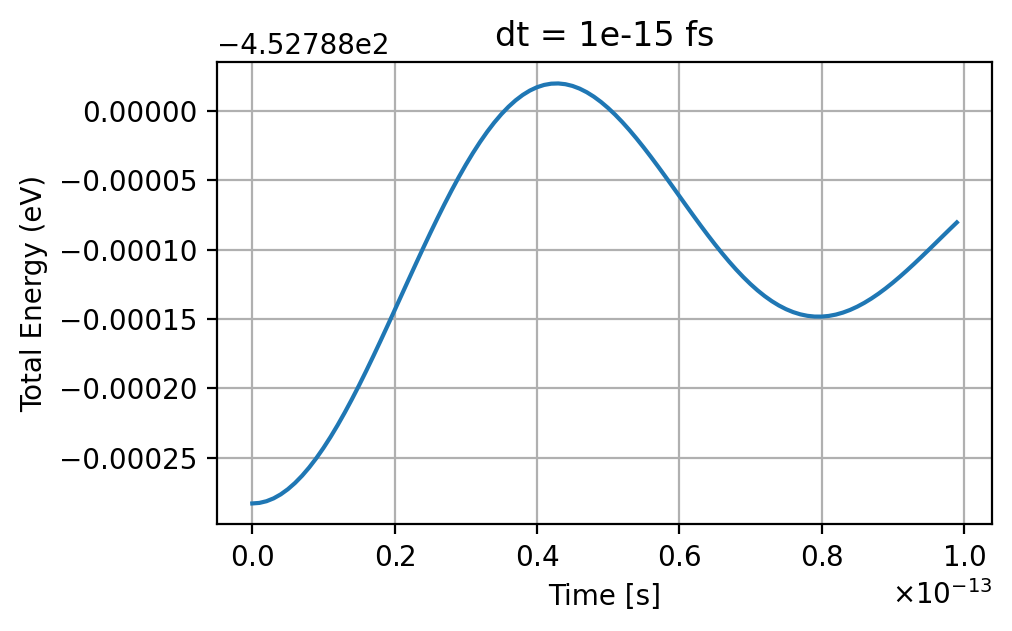

In [9]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0, 100, 1) * dt
y = meta_E_tot[:100]

plt.figure(figsize=(5,3), dpi=200)
plt.plot(x, y)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.xlabel('Time [s]')
plt.ylabel('Total Energy (eV)')
plt.title(f'dt = {dt} fs')
plt.grid()
plt.show()

In [10]:
meta_T

[np.float64(20.02083908995596),
 np.float64(20.01572059961338),
 np.float64(19.984663836001886),
 np.float64(19.927835628446992),
 np.float64(19.845537185726627),
 np.float64(19.738202146874563),
 np.float64(19.60639386332563),
 np.float64(19.450801919878295),
 np.float64(19.272237915380998),
 np.float64(19.071630528347807),
 np.float64(18.850019896902708),
 np.float64(18.60855134652507),
 np.float64(18.348468503010732),
 np.float64(18.071105831847753),
 np.float64(17.77788064881746),
 np.float64(17.47028465004624),
 np.float64(17.149875012928305),
 np.float64(16.81826512229151),
 np.float64(16.47711497886079),
 np.float64(16.128121349460603),
 np.float64(15.77300772046578),
 np.float64(15.413514117728178),
 np.float64(15.05138685755405),
 np.float64(14.688368294255696),
 np.float64(14.326186630329653),
 np.float64(13.9665458554007),
 np.float64(13.611115879698632),
 np.float64(13.261522926987535),
 np.float64(12.919340250534752),
 np.float64(12.586079233882481),
 np.float64(12.2631809

### Step: 5 femtoseconds

In [11]:
# instantiation
cristallo2 = Crystal.from_file(filename)
# cutoff radious
cristallo2.set_R_C(4.5)
# neighbours
cristallo2.find_neighbours() 

In [12]:
from libraries.CrystalDynamics import CrystalDynamics as Dynamics
# choose a time step dt = 5 fs
dt2 = 2e-15
T2=1600

In [13]:
simulazione2 = Dynamics(cristallo2, atomic_mass=silver_mass, dt=dt2, temp_ini=T2)
simulazione2.set_seed(12316543)
meta_E_tot2, meta_E_K2, meta_T2 = simulazione2.run_dynamics(n_steps=1000, output=True, debug=False)

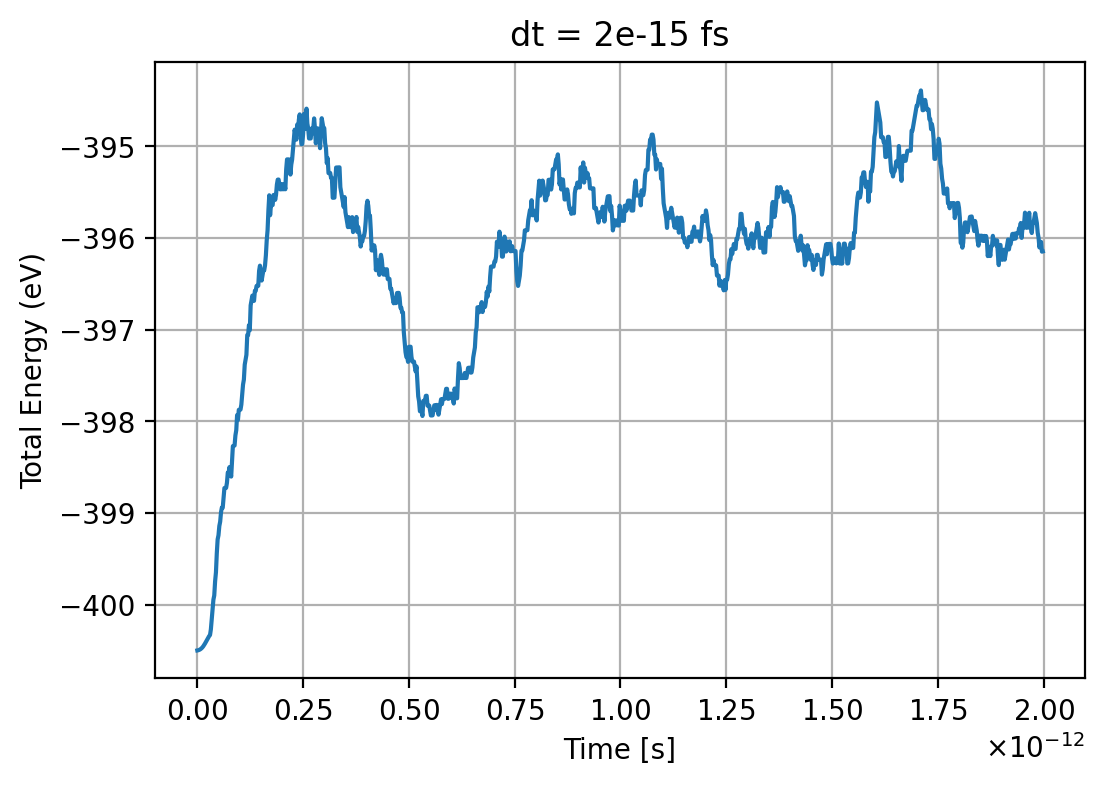

In [14]:
import matplotlib.pyplot as plt
import numpy as np
x2 = np.arange(0, 1000, 1) * dt2
y2 = meta_E_tot2#[:100]

plt.figure(figsize=(6,4), dpi=200)
plt.plot(x2, y2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)
plt.xlabel('Time [s]')
plt.ylabel('Total Energy (eV)')
plt.title(f'dt = {dt2} fs')
plt.grid()
plt.show()